<a href="https://colab.research.google.com/github/CoreTheGreat/HBPU-Machine-Learning-Course/blob/main/ML_Chapter3_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 第三章：分类
湖北理工学院《机器学习》课程资料

作者：李辉楚吴

笔记内容概述:
* 3.1 逻辑回归与二分类问题
* 3.2 常用的二分类模型——支持向量机
* 3.3 常用的二分类模型——决策树
* 3.4 二分类模型的度量
* 3.5 由二分类到多分类
* 3.6 实验3：基于机器学习方法的手写字母识别


## 3.1 逻辑回归与二分类问题

3.1.1 利用torchvision载入训练数据MINST

MINST是一个小型的基于灰度图像(图像大小1x28x28)的手写字母识别数据集，包含60000个训练数据，10000个测试数据。

--2024-08-25 12:31:00--  https://www.wfonts.com/download/data/2014/06/01/simhei/chinese.simhei.ttf
Resolving www.wfonts.com (www.wfonts.com)... 172.67.129.58, 104.21.1.127, 2606:4700:3037::6815:17f, ...
Connecting to www.wfonts.com (www.wfonts.com)|172.67.129.58|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10050870 (9.6M) [application/octetstream]
Saving to: ‘simhei.ttf’

simhei.ttf          100%[===================>]   9.58M  7.19MB/s    in 1.3s    

2024-08-25 12:31:02 (7.19 MB/s) - ‘simhei.ttf’ saved [10050870/10050870]

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 45131191.65it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 1960886.00it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 13741009.68it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 2125937.82it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



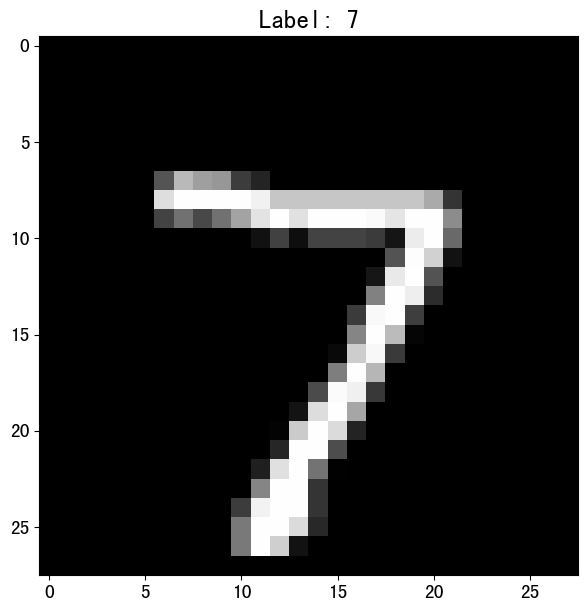

In [3]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim

import numpy as np

from sklearn import svm
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.multiclass import OneVsOneClassifier
from sklearn.metrics import roc_curve, auc

import time

# Chinese support
!wget -O simhei.ttf 'https://www.wfonts.com/download/data/2014/06/01/simhei/chinese.simhei.ttf'
import matplotlib
import matplotlib.pyplot as plt
matplotlib.font_manager.fontManager.addfont('simhei.ttf') # Add the font
matplotlib.rc('font', family='SimHei') # Set the font

color_list = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

label_size = 18 # Label size
ticklabel_size = 14 # Tick label size

# Load the MNIST dataset to display
imgDisp = torchvision.datasets.MNIST(root='./data', train=False, download=True)
img, label = imgDisp[0]

fig, ax = plt.subplots(figsize=(7,7))
ax.imshow(img, cmap='gray')
ax.tick_params(axis='both', which='major', labelsize=ticklabel_size) # Set tick label size
ax.set_title(f"Label: {label}", fontsize=label_size)
plt.savefig(f'exp_character{label}.png', dpi=300) # Make figure clearer
plt.show()

In [4]:
class ftrExtract(object):
    def __call__(self, tensor):
        tensor = tensor.squeeze()

        mean_width = tensor.mean(axis=0)
        mean_height = tensor.mean(axis=1)

        std_width = tensor.std(axis=0)
        std_height = tensor.std(axis=1)

        ftrs = torch.cat([mean_width, mean_height, std_width, std_height])

        return ftrs

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(), ftrExtract()])

# Load the MNIST dataset
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Count number of each class in trainset
train_class_counts = {}
for _, label in trainset:
    if label not in train_class_counts:
        train_class_counts[label] = 0
    train_class_counts[label] += 1

# Count number of each class in testset
test_class_counts = {}
for _, label in testset:
    if label not in test_class_counts:
        test_class_counts[label] = 0
    test_class_counts[label] += 1

# Print results
for i in range(10):
    cls_counts_train = train_class_counts.get(i, 0)
    cls_ratio_train = cls_counts_train / len(trainset)
    cls_counts_test = test_class_counts.get(i, 0)
    cls_ratio_test = cls_counts_test / len(testset)

    print(f"Class {i}: Trainset - {cls_counts_train} ({cls_ratio_train:.2%}), Testset - {cls_counts_test} ({cls_ratio_test:.2%})")

batch_size = 42
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

# Get a batch of training data
dataiter = iter(trainloader)
data, labels = next(dataiter)

input_size = data[0].numpy().shape[0]
print(f'Input_size is {input_size}')

Class 0: Trainset - 5923 (9.87%), Testset - 980 (9.80%)
Class 1: Trainset - 6742 (11.24%), Testset - 1135 (11.35%)
Class 2: Trainset - 5958 (9.93%), Testset - 1032 (10.32%)
Class 3: Trainset - 6131 (10.22%), Testset - 1010 (10.10%)
Class 4: Trainset - 5842 (9.74%), Testset - 982 (9.82%)
Class 5: Trainset - 5421 (9.04%), Testset - 892 (8.92%)
Class 6: Trainset - 5918 (9.86%), Testset - 958 (9.58%)
Class 7: Trainset - 6265 (10.44%), Testset - 1028 (10.28%)
Class 8: Trainset - 5851 (9.75%), Testset - 974 (9.74%)
Class 9: Trainset - 5949 (9.92%), Testset - 1009 (10.09%)
Input_size is 112


3.1.2 使用线性回归识别手写字母

In [5]:
# Define linear regression model
model = nn.Linear(input_size, 1, device=device)

# Define loss function
criterion = nn.MSELoss()

# Use Stochastic Gradient Descent optimizer
optimizer = optim.Adam(model.parameters(), lr=0.03)

max_epoch = 10
for epoch in range(max_epoch):  # loop over the dataset multiple times
    for i, (batch_image, batch_label) in enumerate(trainloader):
        # Flatten images
        batch_image = batch_image.view(-1, input_size)
        batch_label = batch_label.float()

        # Forward pass
        batch_pred = model(batch_image)
        loss = criterion(batch_pred.squeeze(), batch_label)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print propress
        if (i+1) % 1000 == 0:
            print(f'Epoch [{epoch+1}/{max_epoch}], Step [{i+1}/{len(trainloader)}], Loss: {loss.item():.4f}')

    # Evaluation on test set
    with torch.no_grad():
        total_error = 0
        for x, y in testloader:
            y = y.squeeze().float()

            x = x.view(-1, input_size)
            y_pred = model(x).squeeze()

            total_error += torch.sum((torch.abs(y_pred - y) < 0.5).float())  # Calculate mean absolute error

        avg_error = total_error / len(testloader.dataset)
        print(f"Average error on test set: {avg_error.item():.4f}")

Epoch [1/10], Step [1000/1429], Loss: 3.1175
Average error on test set: 0.2069
Epoch [2/10], Step [1000/1429], Loss: 3.1234
Average error on test set: 0.2193
Epoch [3/10], Step [1000/1429], Loss: 2.9419
Average error on test set: 0.2244
Epoch [4/10], Step [1000/1429], Loss: 2.5246
Average error on test set: 0.1873
Epoch [5/10], Step [1000/1429], Loss: 3.1975
Average error on test set: 0.2251
Epoch [6/10], Step [1000/1429], Loss: 2.5006
Average error on test set: 0.2053
Epoch [7/10], Step [1000/1429], Loss: 4.1863
Average error on test set: 0.2154
Epoch [8/10], Step [1000/1429], Loss: 3.1711
Average error on test set: 0.2162
Epoch [9/10], Step [1000/1429], Loss: 2.6091
Average error on test set: 0.2361
Epoch [10/10], Step [1000/1429], Loss: 3.7038
Average error on test set: 0.2301


3.1.3 使用逻辑回归识别手写字母"1"

构建二分类数据集

In [6]:
# Extract features and labels from trainset
x_train = []
y_train = []
for image, label in trainset:
    x_train.append(image.numpy())
    y_train.append(1 if label == 1 else 0)  # Set label to 1 for character 1, 0 otherwise

x_train = np.array(x_train)
y_train = np.array(y_train)

# Extract features and labels from trainset
x_test = []
y_test = []
for image, label in testset:
    x_test.append(image.numpy())
    y_test.append(1 if label == 1 else 0)  # Set label to 1 for character 1, 0 otherwise

x_test = np.array(x_test)
y_test = np.array(y_test)

训练逻辑回归模型

In [7]:
# Define logic regression model
mdl_logic = LogisticRegression(max_iter=1000)

# Train model
start_time = time.time()
mdl_logic.fit(x_train, y_train)
end_time = time.time()

print(f'Training time: {end_time - start_time:.2f} seconds')

Training time: 2.64 seconds


模型测试

In [8]:
y_pred_logic = mdl_logic.predict(x_test)
y_proba_logic = mdl_logic.predict_proba(x_test) # Output ratio

accuracy = accuracy_score(y_test, y_pred_logic)
precision = precision_score(y_test, y_pred_logic)
recall = recall_score(y_test, y_pred_logic)
f1 = f1_score(y_test, y_pred_logic)

print(f'Precision: {precision:.4f}, Recall: {recall:.4f}, Accuracy: {accuracy:.4f}, F1-Score: {f1:.4f}')

Precision: 0.9719, Recall: 0.9445, Accuracy: 0.9906, F1-Score: 0.9580


案例演示：随机选取图片，输出判断结果

Sample 1: imgDisp label is 1, x label is 1


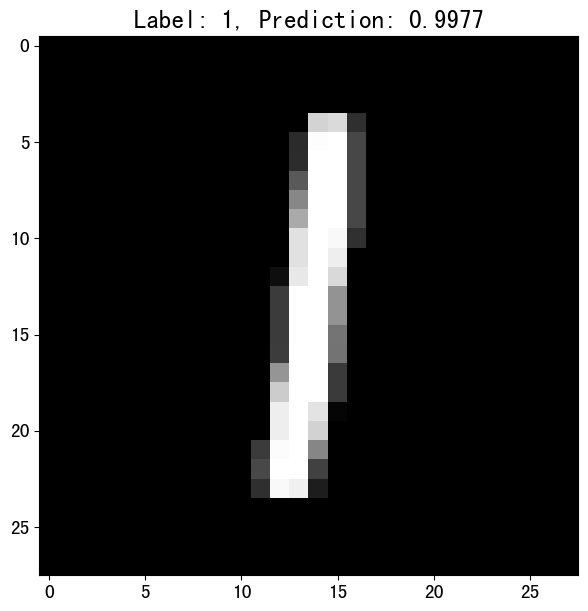

Sample 2: imgDisp label is 6, x label is 0


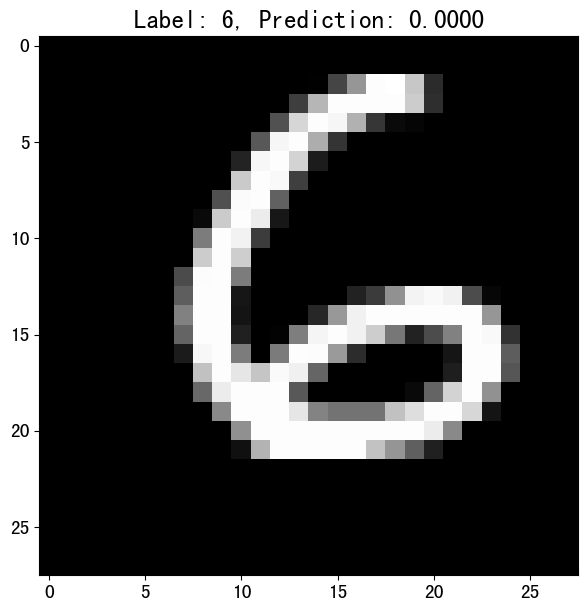

Sample 3: imgDisp label is 2, x label is 0


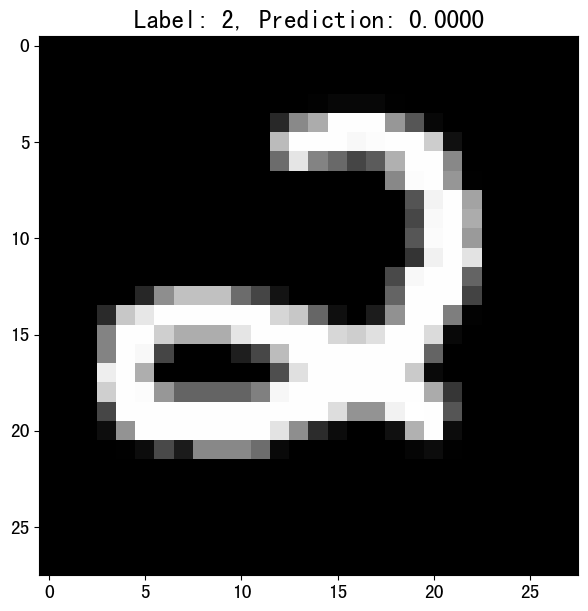

In [9]:
# Random select 3 examples from imgDisp and testset
np.random.seed(42)
idx = np.random.choice(len(imgDisp), 3)

# Select instances
imgDisp_select = [imgDisp[i] for i in idx]
x_select = x_test[idx]
y_select = y_test[idx]

y_select_proba = mdl_logic.predict_proba(x_select)

# Check the selected instances' labels are the same
for i in range(len(idx)):
    print(f'Sample {i+1}: imgDisp label is {imgDisp_select[i][1]}, x label is {y_select[i]}')

    # Display image from imgDisp
    fig, ax = plt.subplots(figsize=(7,7))
    ax.imshow(imgDisp_select[i][0], cmap='gray')
    ax.tick_params(axis='both', which='major', labelsize=ticklabel_size) # Set tick label size
    ax.set_title(f"Label: {imgDisp_select[i][1]}, Prediction: {y_select_proba[i,1]:.4f}", fontsize=label_size)

    plt.savefig(f'binary_prediction_{i+1}.png', dpi=300) # Make figure clearer
    plt.show()

## 3.2 常用的二分类模型——支持向量机

In [10]:
# Define SVM classifier
mdl_svm = svm.SVC(kernel='linear', probability=True)

# Train model
start_time = time.time()
mdl_svm.fit(x_train, y_train)
end_time = time.time()

print(f'Training time: {end_time - start_time:.2f} seconds')

Training time: 174.53 seconds


In [11]:
# Make predictions and evaluate the model
y_pred_svm = mdl_svm.predict(x_test)
y_proba_svm = mdl_svm.predict_proba(x_test) # Output ratio

accuracy = accuracy_score(y_test, y_pred_svm)
precision = precision_score(y_test, y_pred_svm)
recall = recall_score(y_test, y_pred_svm)
f1 = f1_score(y_test, y_pred_svm)

print(f'Precision: {precision:.4f}, Recall: {recall:.4f}, Accuracy: {accuracy:.4f}, F1-Score: {f1:.4f}')

Precision: 0.9755, Recall: 0.9454, Accuracy: 0.9911, F1-Score: 0.9602


## 3.3 常用的二分类模型——决策树和随机森林

In [12]:
# Define DecisionTree classifier
mdl_dt = tree.DecisionTreeClassifier()

# Train model
start_time = time.time()
mdl_dt.fit(x_train, y_train)
end_time = time.time()

print(f'Training time: {end_time - start_time:.2f} seconds')

# Define Random Forest classifier
mdl_rf = RandomForestClassifier(n_estimators=100)

# Train model
start_time = time.time()
mdl_rf.fit(x_train, y_train)
end_time = time.time()

print(f'Training time: {end_time - start_time:.2f} seconds')

Training time: 11.76 seconds
Training time: 50.59 seconds


In [13]:
y_pred_dt = mdl_dt.predict(x_test)
y_proba_dt = mdl_dt.predict_proba(x_test) # Output ratio

accuracy = accuracy_score(y_test, y_pred_dt)
precision = precision_score(y_test, y_pred_dt)
recall = recall_score(y_test, y_pred_dt)
f1 = f1_score(y_test, y_pred_dt)

print(f'Precision: {precision:.4f}, Recall: {recall:.4f}, Accuracy: {accuracy:.4f}, F1-Score: {f1:.4f}')

y_pred_rf = mdl_rf.predict(x_test)
y_proba_rf = mdl_rf.predict_proba(x_test) # Output ratio

accuracy = accuracy_score(y_test, y_pred_rf)
precision = precision_score(y_test, y_pred_rf)
recall = recall_score(y_test, y_pred_rf)
f1 = f1_score(y_test, y_pred_rf)

print(f'Precision: {precision:.4f}, Recall: {recall:.4f}, Accuracy: {accuracy:.4f}, F1-Score: {f1:.4f}')

Precision: 0.9123, Recall: 0.9251, Accuracy: 0.9814, F1-Score: 0.9186
Precision: 0.9897, Recall: 0.9348, Accuracy: 0.9915, F1-Score: 0.9615


## 3.4 二分类模型的度量

准确率、召回率、敏感性、特异性、精确度、F1-Score

In [14]:
def cls_counts(y_test, y_proba, th=0.5):
    y_pred = (y_proba[:,1] > th).astype(int)

    tp_idx = (y_test == 1) & (y_pred == 1)
    fp_idx = (y_test == 0) & (y_pred == 1)
    tn_idx = (y_test == 0) & (y_pred == 0)
    fn_idx = (y_test == 1) & (y_pred == 0)

    tp = np.sum(tp_idx)
    fp = np.sum(fp_idx)
    tn = np.sum(tn_idx)
    fn = np.sum(fn_idx)

    return th, (tp, fp, tn, fn)

th, (tp, fp, tn, fn) = cls_counts(y_test, y_proba_logic)
print(f'Threshold {th}, TP: {tp}, FP: {fp}, TN: {tn}, FN: {fn}')

Threshold 0.5, TP: 1072, FP: 31, TN: 8834, FN: 63


Precision: 0.9719, Recall (Sensitivity): 0.9445, Specificity: 0.9965, Accuracy: 0.9906, F1-Score: 0.9580


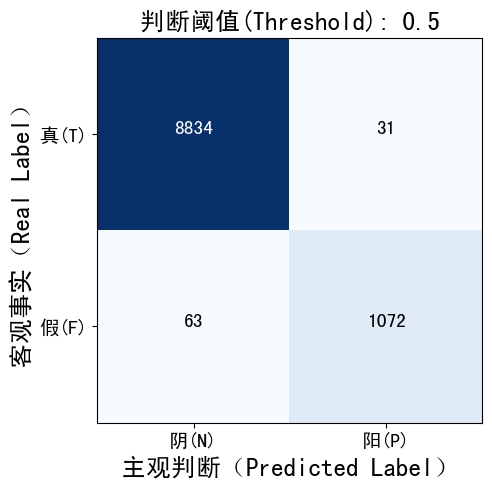

In [15]:
def plot_confusion_matrix(th, tp, fp, tn, fn):
    """Plots a confusion matrix given the number of true positives, false positives,
    true negatives, and false negatives."""
    global label_size, ticklabel_size # Set global variables of font size

    cm = np.array([[tn, fp], [fn, tp]])

    # Display the confusion matrix as a heatmap
    fig, ax = plt.subplots(figsize=(5,5))
    img = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)

    # Add labels to the axes
    tick_marks = np.arange(2)
    ax.set_xticks(tick_marks, ['阴(N)', '阳(P)'], fontsize=ticklabel_size)
    ax.set_yticks(tick_marks, ['真(T)', '假(F)'], fontsize=ticklabel_size)

    # Add the count of each category to the plot
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                     fontsize=ticklabel_size,
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    ax.tick_params(axis='both', which='major', labelsize=ticklabel_size) # Set tick label size

    ax.set_ylabel('客观事实（Real Label）', fontsize=label_size)
    ax.set_xlabel('主观判断（Predicted Label）', fontsize=label_size)
    ax.set_title(f'判断阈值(Threshold): {th}', fontsize=label_size)

    return fig, ax

def get_scores(tp, fp, tn, fn):
    precision = tp / (tp + fp)
    recall = tp / (tp + fn) # Also called sensitivity
    accuracy = (tp + tn) / (tp + fp + tn + fn)
    f1 = 2 * precision * recall / (precision + recall)

    specificity = tn / (tn + fp)

    return precision, recall, specificity, accuracy, f1

precision, recall, specificity, accuracy, f1 = get_scores(tp, fp, tn, fn)
print(f'Precision: {precision:.4f}, Recall (Sensitivity): {recall:.4f}, Specificity: {specificity:.4f}, Accuracy: {accuracy:.4f}, F1-Score: {f1:.4f}')

# Example usage (replace with your actual values)
fig, ax = plot_confusion_matrix(th, tp, fp, tn, fn)

plt.savefig(f'binary_confusion_matrix.png', dpi=300) # Make figure clearer
plt.show()

Precision: 0.7783, Recall (Sensitivity): 0.9806, Specificity: 0.9642, Accuracy: 0.9661, F1-Score: 0.8678


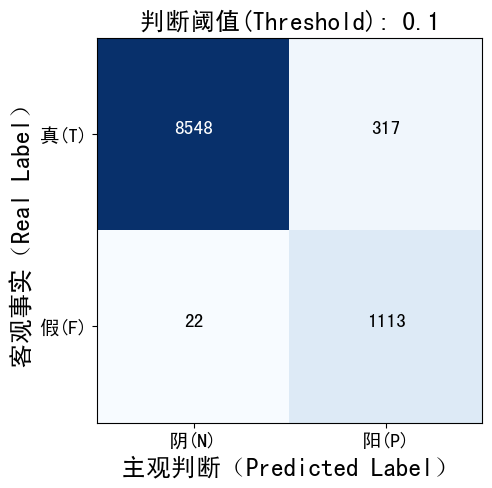

In [16]:
th = 0.1
th, (tp, fp, tn, fn) = cls_counts(y_test, y_proba_logic, th)

precision, recall, specificity, accuracy, f1 = get_scores(tp, fp, tn, fn)
print(f'Precision: {precision:.4f}, Recall (Sensitivity): {recall:.4f}, Specificity: {specificity:.4f}, Accuracy: {accuracy:.4f}, F1-Score: {f1:.4f}')

fig, ax = plot_confusion_matrix(th, tp, fp, tn, fn)
plt.savefig(f'binary_confusion_matrix_0D1.png', dpi=300) # Make figure clearer
plt.show()

Precision: 0.9947, Recall (Sensitivity): 0.6573, Specificity: 0.9995, Accuracy: 0.9607, F1-Score: 0.7915


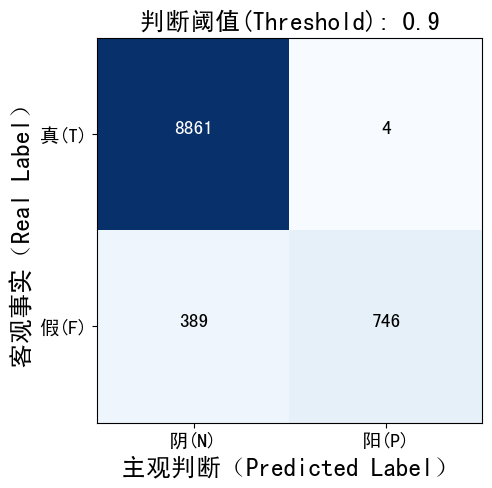

In [17]:
th = 0.9
th, (tp, fp, tn, fn) = cls_counts(y_test, y_proba_logic, th)

precision, recall, specificity, accuracy, f1 = get_scores(tp, fp, tn, fn)
print(f'Precision: {precision:.4f}, Recall (Sensitivity): {recall:.4f}, Specificity: {specificity:.4f}, Accuracy: {accuracy:.4f}, F1-Score: {f1:.4f}')

fig, ax = plot_confusion_matrix(th, tp, fp, tn, fn)
plt.savefig(f'binary_confusion_matrix_0D9.png', dpi=300) # Make figure clearer
plt.show()

ROC（Receiver operating characteristic curve）接收者操作特征曲线

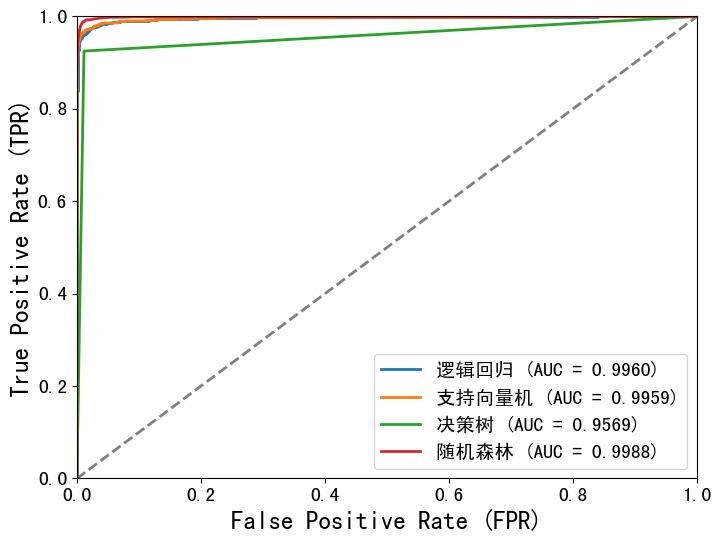

In [18]:
def plot_roc_curve_base():
    """Plots the ROC curve and computes AUC."""
    global label_size, ticklabel_size # Set global variables of font size

    fig, ax = plt.subplots(figsize=(8,6))

    ax.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.0])
    ax.tick_params(axis='both', which='major', labelsize=ticklabel_size) # Set tick label size

    ax.set_xlabel('False Positive Rate (FPR)', fontsize=label_size)
    ax.set_ylabel('True Positive Rate (TPR)', fontsize=label_size)

    return fig, ax

def add_roc_curve(ax, y_true, y_proba, curve_color, curve_label):
    """Plots the ROC curve and computes AUC."""

    fpr, tpr, thresholds = roc_curve(y_true, y_proba)
    roc_auc = auc(fpr, tpr)

    roc = ax.plot(fpr, tpr, color=curve_color, lw=2, label=f'{curve_label} (AUC = {roc_auc:.4f})')

    return roc_auc, fpr, tpr, thresholds

fig, ax = plot_roc_curve_base()

roc_auc_logic, fpr_logic, tpr_logic, thresholds_logic = add_roc_curve(ax, y_test, y_proba_logic[:,1], color_list[0], '逻辑回归')
roc_auc_logic, fpr_logic, tpr_logic, thresholds_logic = add_roc_curve(ax, y_test, y_proba_svm[:,1], color_list[1], '支持向量机')
roc_auc_logic, fpr_logic, tpr_logic, thresholds_logic = add_roc_curve(ax, y_test, y_proba_dt[:,1], color_list[2], '决策树')
roc_auc_logic, fpr_logic, tpr_logic, thresholds_logic = add_roc_curve(ax, y_test, y_proba_rf[:,1], color_list[3], '随机森林')

plt.legend(loc="lower right", fontsize=ticklabel_size)
plt.savefig(f'binary_roc_curve.png', dpi=300) # Make figure clearer
plt.show()


## 3.5 由二分类到多分类

In [19]:
# Extract features and labels from trainset
x_train = []
y_train = []
for image, label in trainset:
    x_train.append(image.numpy())
    y_train.append(label)

x_train = np.array(x_train)
y_train = np.array(y_train)

# Extract features and labels from trainset
x_test = []
y_test = []
for image, label in testset:
    x_test.append(image.numpy())
    y_test.append(label)

x_test = np.array(x_test)
y_test = np.array(y_test)

3.5.1 一对多（One-vs-Rest）方法

In [20]:
# Define logic multi-classifier
mdl_logic_ovr = OneVsRestClassifier(LogisticRegression(max_iter=1000))

# Train model
start_time = time.time()
mdl_logic_ovr.fit(x_train, y_train)
end_time = time.time()

print(f'Training time: {end_time - start_time:.2f} seconds')

# Make predictions and evaluate the model
y_pred_logic_ovr = mdl_logic_ovr.predict(x_test)
y_proba_logic_ovr = mdl_logic_ovr.predict_proba(x_test) # Output ratio

accuracy = accuracy_score(y_test, y_pred_logic_ovr)
print(f'Accuracy: {accuracy:.4f}')

Training time: 30.84 seconds
Accuracy: 0.8536


In [21]:
# Get class list: 0, 1, ..., 9
class_list = np.sort(np.unique(y_train))

# Create model list
mdl_logic_list = []
for c in class_list:
    mdl_logic_list.append(LogisticRegression(max_iter=1000))

# Train models seperately
for i in range(len(class_list)):
    start_time = time.time()
    mdl_logic_list[i].fit(x_train, (y_train == class_list[i]).astype(int))
    end_time = time.time()
    print(f'Training class {class_list[i]}, Training time: {end_time - start_time:.2f} seconds')

Training class 0, Training time: 2.72 seconds
Training class 1, Training time: 1.67 seconds
Training class 2, Training time: 2.94 seconds
Training class 3, Training time: 4.20 seconds
Training class 4, Training time: 2.34 seconds
Training class 5, Training time: 3.05 seconds
Training class 6, Training time: 2.07 seconds
Training class 7, Training time: 2.01 seconds
Training class 8, Training time: 5.17 seconds
Training class 9, Training time: 4.07 seconds


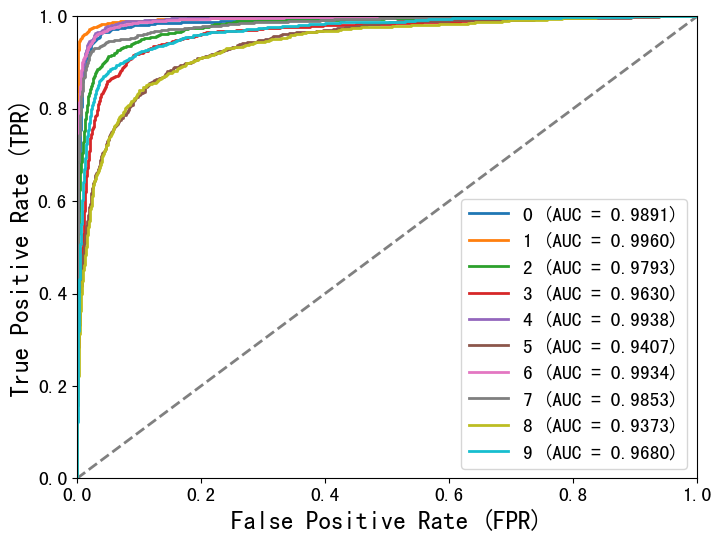

In [24]:
# Plot ROC curve
fig, ax = plot_roc_curve_base()

# Draw ROC of individual classifier
for i in range(len(class_list)):
    # Make predictions and evaluate the model
    y_test_trans = (y_test == class_list[i]).astype(int)
    y_proba = mdl_logic_list[i].predict_proba(x_test) # Output ratio

    roc_auc_logic, fpr_logic, tpr_logic, thresholds_logic = add_roc_curve(ax, y_test_trans, y_proba[:,1], color_list[i], f'{class_list[i]}')

plt.legend(loc="lower right", fontsize=ticklabel_size)
plt.savefig(f'binary_roc_curve_ovr.png', dpi=300) # Make figure clearer
plt.show()

Sample 1: imgDisp label is 9, testset label is 9, predict label is 9
Sample 2: imgDisp label is 2, testset label is 2, predict label is 0
Sample 3: imgDisp label is 2, testset label is 2, predict label is 2
Sample 4: imgDisp label is 9, testset label is 9, predict label is 8
Sample 5: imgDisp label is 8, testset label is 8, predict label is 8
Sample 6: imgDisp label is 5, testset label is 5, predict label is 5
Sample 7: imgDisp label is 7, testset label is 7, predict label is 7
Sample 8: imgDisp label is 7, testset label is 7, predict label is 7
Sample 9: imgDisp label is 4, testset label is 4, predict label is 4
Sample 10: imgDisp label is 5, testset label is 5, predict label is 5


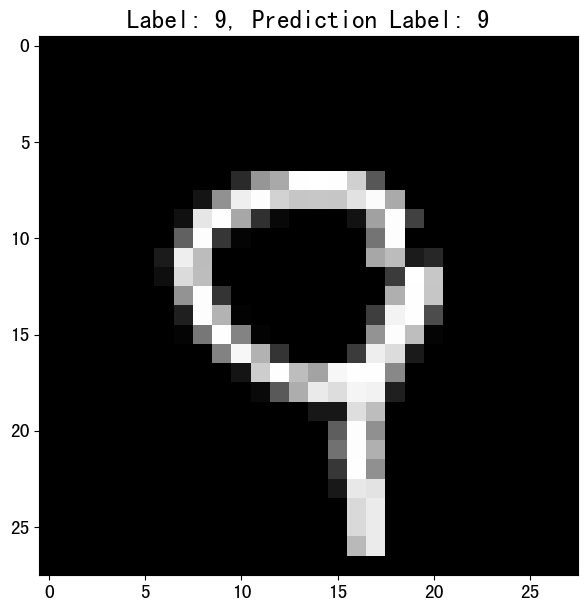

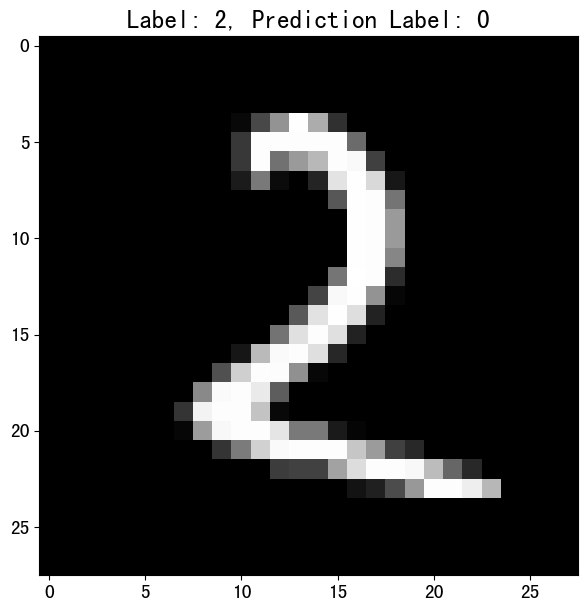

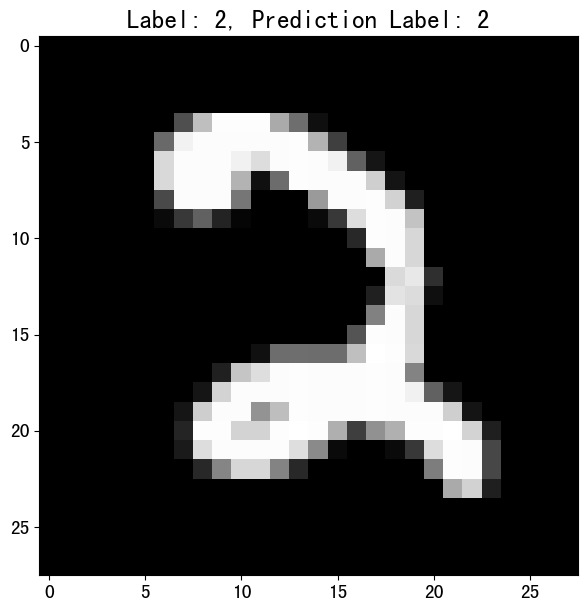

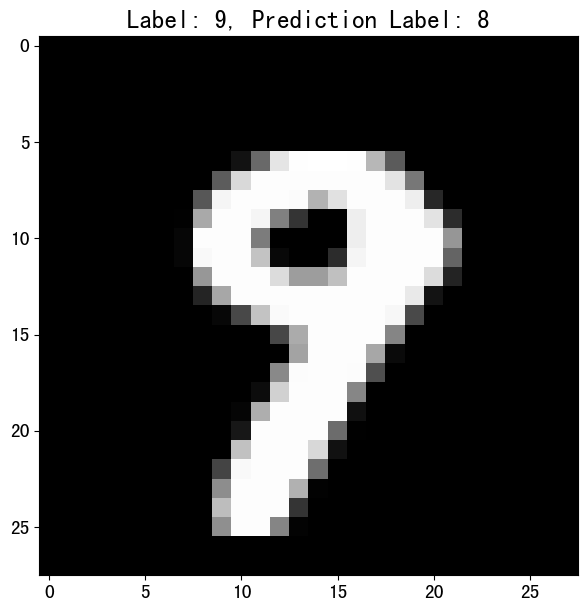

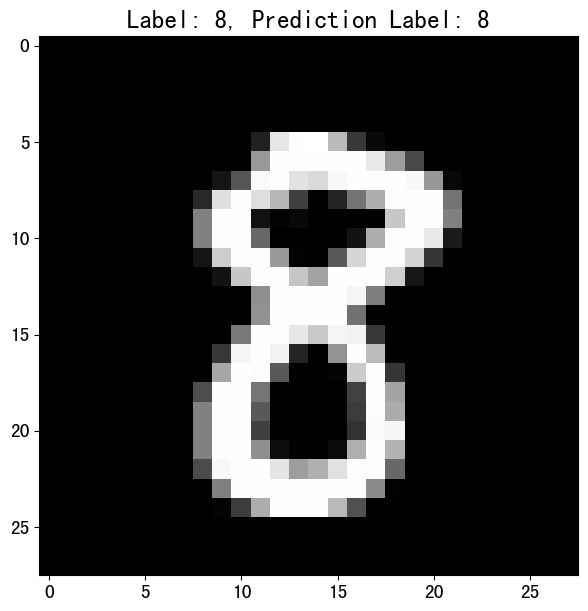

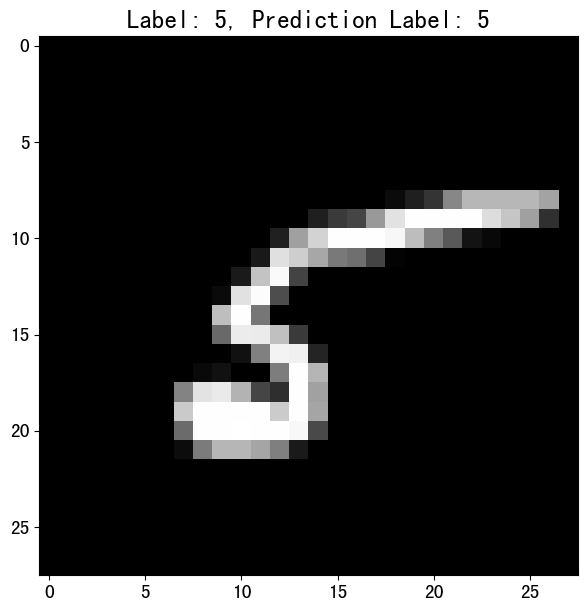

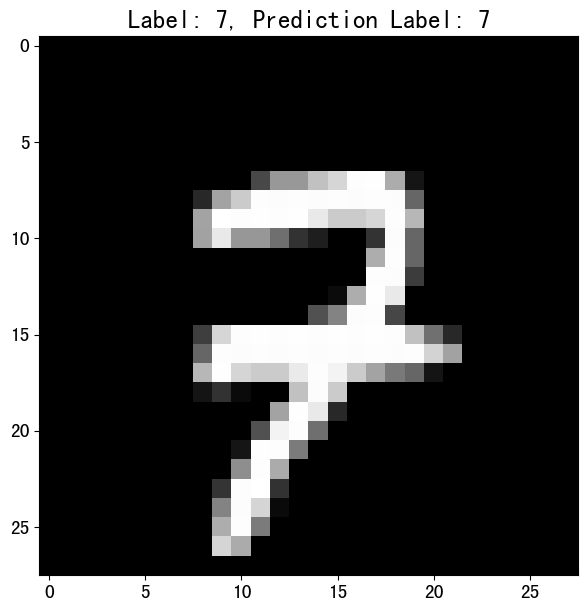

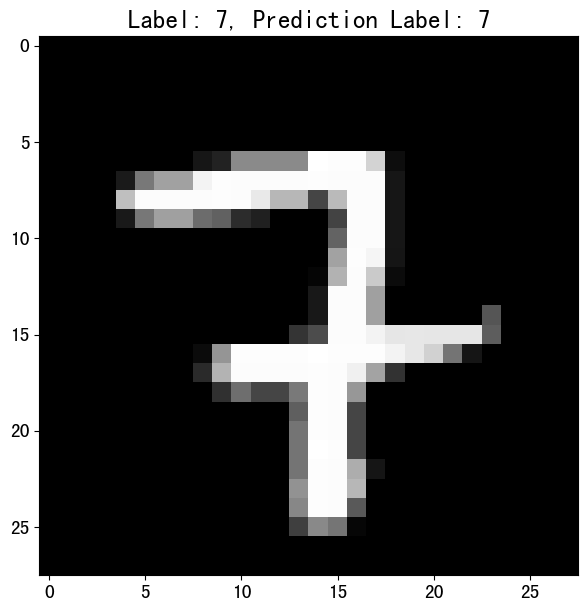

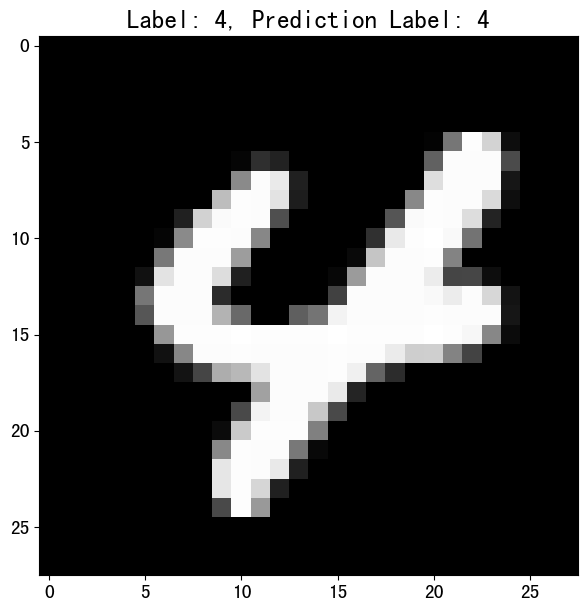

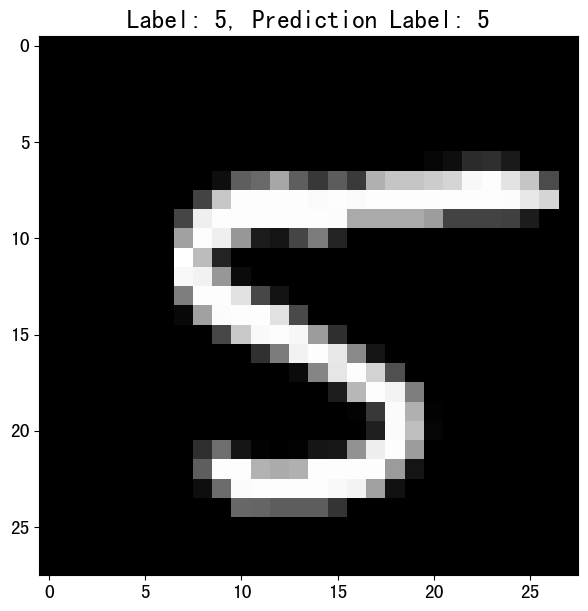

In [25]:
sample_num = 10

# Random select 3 examples from imgDisp and testset
np.random.seed(1)
idx = np.random.choice(len(imgDisp), sample_num)

# Select instances
imgDisp_select = [imgDisp[i] for i in idx]
testset_select = [testset[i] for i in idx]

# Check the selected instances' labels are the same
for i in range(sample_num):
    x = testset_select[i][0].view(-1, input_size)

    # Using model to predict character
    y_pred_list = []
    for j in range(len(mdl_logic_list)):
        y_pred_list.append(mdl_logic_list[j].predict(x))

    y_pred = np.argmax(np.array(y_pred_list), axis=0)[0]

    # Display image from imgDisp
    fig, ax = plt.subplots(figsize=(7,7))
    ax.imshow(imgDisp_select[i][0], cmap='gray')
    ax.tick_params(axis='both', which='major', labelsize=ticklabel_size) # Set tick label size
    ax.set_title(f"Label: {imgDisp_select[i][1]}, Prediction Label: {y_pred}", fontsize=label_size)

    print(f'Sample {i+1}: imgDisp label is {imgDisp_select[i][1]}, testset label is {testset_select[i][1]}, predict label is {y_pred}')

In [26]:
# Prediction
y_pred_list = []
for i in range(len(mdl_logic_list)):
    y_pred_list.append(mdl_logic_list[i].predict(x_test))

y_pred = np.argmax(np.array(y_pred_list), axis=0)

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')

Accuracy: 0.7572


混淆矩阵

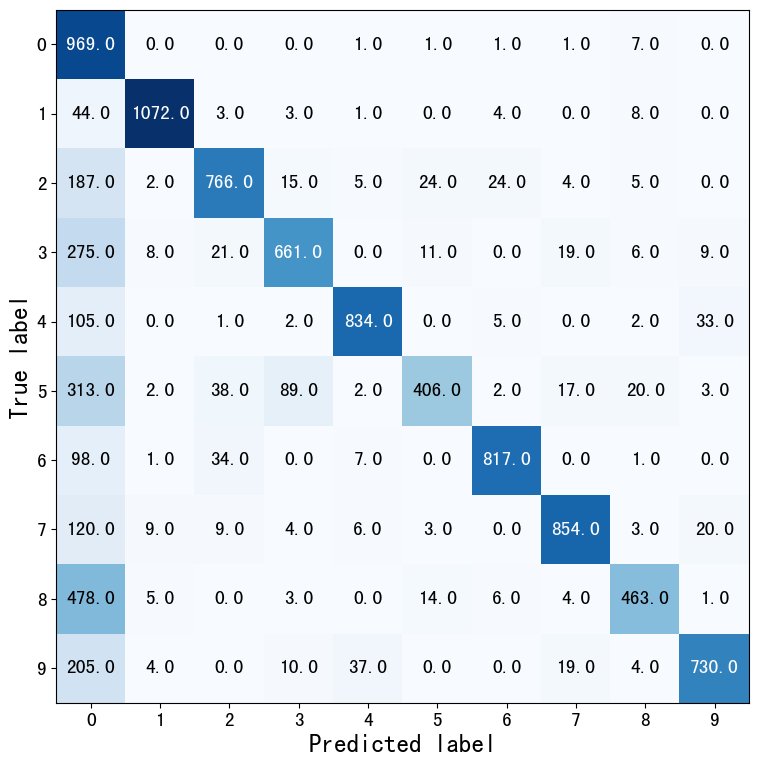

In [27]:
# Create confusion matrix
cm_test = np.zeros((10, 10))
for i in range(len(y_test)):
    cm_test[y_test[i], y_pred[i]] += 1

# Display confusion matrix
fig, ax = plt.subplots(figsize=(9,9))
im = ax.imshow(cm_test, cmap=plt.cm.Blues, interpolation='nearest')

# Loop over data dimensions and create text annotations.
for i in range(cm_test.shape[0]):
    for j in range(cm_test.shape[1]):
        ax.text(j, i, cm_test[i, j], fontsize=ticklabel_size, ha="center", va="center",
                color="white" if cm_test[i, j] > cm_test.max() / 2. else "black")

ax.set_xlabel('Predicted label', fontsize=label_size)
ax.set_ylabel('True label', fontsize=label_size)

ax.set_xticks(np.arange(10))
ax.set_xticklabels(np.arange(10))

ax.set_yticks(np.arange(10))
ax.set_yticklabels(np.arange(10))

ax.tick_params(axis='both', which='major', labelsize=ticklabel_size)

plt.savefig(f'confusion_matrix_numel.png', dpi=300) # Make figure clearer

plt.show()

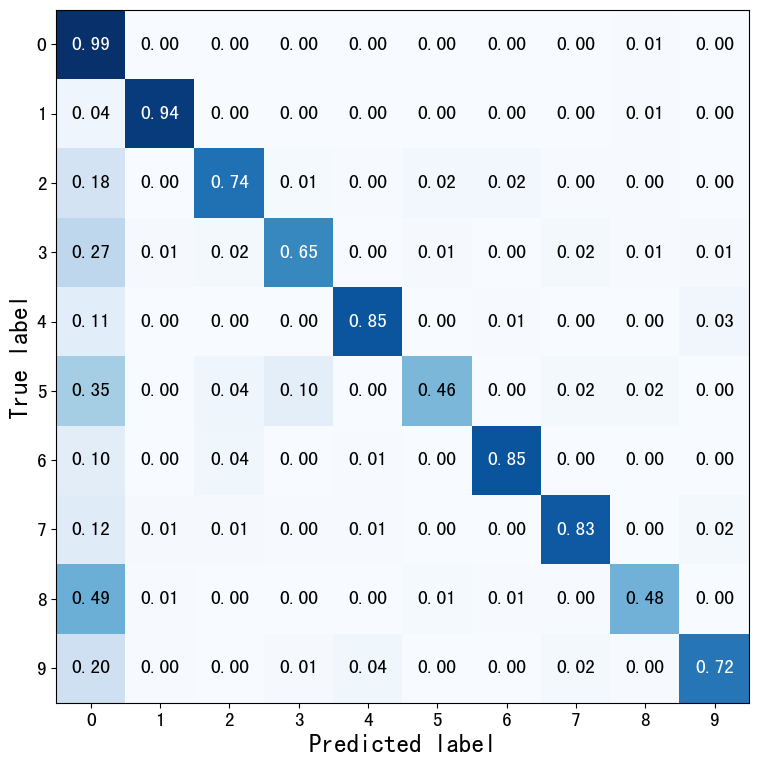

In [28]:
# Create confusion matrix
cm_test = np.zeros((10, 10))
for i in range(len(y_test)):
    cm_test[y_test[i], y_pred[i]] += 1

# Change value to ratio
cm_test = cm_test / np.sum(cm_test, axis=1, keepdims=True)

# Display confusion matrix
fig, ax = plt.subplots(figsize=(9,9))
im = ax.imshow(cm_test, cmap=plt.cm.Blues, interpolation='nearest')

# Loop over data dimensions and create text annotations.
for i in range(cm_test.shape[0]):
    for j in range(cm_test.shape[1]):
        ax.text(j, i, format(cm_test[i, j], '.2f'), fontsize=ticklabel_size, ha="center", va="center",
                color="white" if cm_test[i, j] > cm_test.max() / 2. else "black")

ax.set_xlabel('Predicted label', fontsize=label_size)
ax.set_ylabel('True label', fontsize=label_size)

ax.set_xticks(np.arange(10))
ax.set_xticklabels(np.arange(10))

ax.set_yticks(np.arange(10))
ax.set_yticklabels(np.arange(10))

ax.tick_params(axis='both', which='major', labelsize=ticklabel_size)

plt.savefig(f'confusion_matrix_ratio.png', dpi=300) # Make figure clearer

plt.show()

3.5.2 一对一（One-vs-One）方法

In [29]:
# Define logic regression classifier
mdl_logic_ovo = OneVsOneClassifier(LogisticRegression(max_iter=1000))

# Train model
start_time = time.time()
mdl_logic_ovo.fit(x_train, y_train)
end_time = time.time()

print(f'Training time: {end_time - start_time:.2f} seconds')

# Make predictions and evaluate the model
y_pred = mdl_logic_ovo.predict(x_test)

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')

Training time: 8.38 seconds
Accuracy: 0.8777


In [30]:
# Get class list: 0, 1, ..., 9
class_list = np.sort(np.unique(y_train))

# Create model matrix to save models
mdl_logic_matrix = {}
for cls_p in class_list:
    mdl_logic_matrix[cls_p] = {}
    for cls_n in class_list:
        if cls_p == cls_n:
            continue
        mdl_logic_matrix[cls_p][cls_n] = LogisticRegression(max_iter=1000)

for cls_p in class_list:
    # Training data of positive class
    x_train_ovo_p = x_train[(y_train == cls_p), :]
    y_train_ovo_p = np.ones(x_train_ovo_p.shape[0])

    # Testing data of positive class
    x_test_ovo_p = x_test[(y_test == cls_p), :]
    y_test_ovo_p = np.ones(x_test_ovo_p.shape[0])

    for cls_n in class_list:
        if cls_p == cls_n:
            continue

        # Training data of negative class
        x_train_ovo_n = x_train[(y_train == cls_n), :]
        y_train_ovo_n = np.zeros(x_train_ovo_n.shape[0])

        # Testing data of negative class
        x_test_ovo_n = x_test[(y_test == cls_n), :]
        y_test_ovo_n = np.zeros(x_test_ovo_n.shape[0])

        # Concatenate data for training
        x_train_ovo = np.concatenate((x_train_ovo_p, x_train_ovo_n), axis=0)
        y_train_ovo = np.concatenate((y_train_ovo_p, y_train_ovo_n), axis=0)

        # Model training
        start_time = time.time()
        mdl_logic_matrix[cls_p][cls_n].fit(x_train_ovo, y_train_ovo)
        end_time = time.time()

        # Concatenate data for testing
        x_test_ovo = np.concatenate((x_test_ovo_p, x_test_ovo_n), axis=0)
        y_test_ovo = np.concatenate((y_test_ovo_p, y_test_ovo_n), axis=0)

        # Test model on sub-task
        y_proba_ovo = mdl_logic_matrix[cls_p][cls_n].predict_proba(x_test_ovo) # Output ratio

        # Display results
        _, (tp, fp, tn, fn) = cls_counts(y_test_ovo, y_proba_ovo)
        precision, recall, specificity, accuracy, f1 = get_scores(tp, fp, tn, fn)
        print(f'Training class {cls_p} ({x_train_ovo_p.shape[0]}) vs class {cls_n} ({x_train_ovo_n.shape[0]}), Training time: {end_time - start_time:.2f} seconds, Precision: {precision:.4f}, Recall (Sensitivity): {recall:.4f}, Specificity: {specificity:.4f}, Accuracy: {accuracy:.4f}, F1-Score: {f1:.4f}')

Training class 0 (5923) vs class 1 (6742), Training time: 0.77 seconds, Precision: 0.9918, Recall (Sensitivity): 0.9918, Specificity: 0.9930, Accuracy: 0.9924, F1-Score: 0.9918
Training class 0 (5923) vs class 2 (5958), Training time: 0.51 seconds, Precision: 0.9828, Recall (Sensitivity): 0.9939, Specificity: 0.9835, Accuracy: 0.9886, F1-Score: 0.9883
Training class 0 (5923) vs class 3 (6131), Training time: 0.29 seconds, Precision: 0.9929, Recall (Sensitivity): 0.9939, Specificity: 0.9931, Accuracy: 0.9935, F1-Score: 0.9934
Training class 0 (5923) vs class 4 (5842), Training time: 0.37 seconds, Precision: 0.9959, Recall (Sensitivity): 0.9898, Specificity: 0.9959, Accuracy: 0.9929, F1-Score: 0.9928
Training class 0 (5923) vs class 5 (5421), Training time: 0.44 seconds, Precision: 0.9698, Recall (Sensitivity): 0.9837, Specificity: 0.9664, Accuracy: 0.9754, F1-Score: 0.9767
Training class 0 (5923) vs class 6 (5918), Training time: 0.41 seconds, Precision: 0.9847, Recall (Sensitivity): 0.

In [31]:
# Select class 1
x_test_select = x_test[:, :]

# Prediction
y_pred_counts = np.zeros((x_test_select.shape[0], len(class_list)))

for cls_p in class_list:
    for cls_n in class_list:
        if cls_p == cls_n:
            continue

        y_pred_counts[:, cls_p] = y_pred_counts[:, cls_p] + mdl_logic_matrix[cls_p][cls_n].predict(x_test_select)

y_pred = np.argmax(y_pred_counts, axis=1)

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')

Accuracy: 0.8781


3.5.3 Softmax回归

In [43]:
mdl_softmax = LogisticRegression(max_iter=1000, multi_class='multinomial', solver='lbfgs')

start_time = time.time()
mdl_softmax.fit(x_train, y_train)
end_time = time.time()

print(f'Training time: {end_time - start_time:.2f} seconds')

# Evaluate accuracy (or other metrics)
y_pred = mdl_softmax.predict(x_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Training time: 29.80 seconds
Accuracy: 0.8736


In [44]:
# One-hot encoding
def one_hot_encode(y, num_classes):
    """Converts integer labels to one-hot encoding."""
    one_hot = np.zeros((y.shape[0], num_classes))
    one_hot[np.arange(y.shape[0]), y] = 1
    return one_hot

# Example usage:
num_classes = len(class_list)
y_train_onehot = one_hot_encode(y_train, num_classes)

# Display one-hot encoding results of ten random sample
for _ in range(10):
    idx = np.random.randint(0, y_train_onehot.shape[0])

    print(f'Sample {idx+1},\t Class {y_train[idx]}: {y_train_onehot[idx,:]}')

Sample 39392,	 Class 8: [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
Sample 43947,	 Class 5: [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
Sample 54079,	 Class 2: [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
Sample 32280,	 Class 8: [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
Sample 33681,	 Class 2: [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
Sample 28889,	 Class 0: [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Sample 26082,	 Class 3: [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
Sample 6220,	 Class 6: [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
Sample 48468,	 Class 4: [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
Sample 45676,	 Class 3: [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]


In [51]:
# Softmax function
def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return e_x / e_x.sum(axis=1, keepdims=True)

# Cross-entropy loss
def cross_entropy_loss(y, y_pred):
    """Compute cross-entropy loss."""
    epsilon = 1e-15  # Small value to avoid log(0)
    loss = -np.sum(y * np.log(y_pred + epsilon)) / y.shape[0]
    return loss

def gradient_descent(x, y, learning_rate, num_iterations):
    """Performs gradient descent optimization."""
    num_samples, num_features = x.shape
    num_classes = y.shape[1]

    # Initialize weights and bias
    w = np.random.randn(num_features, num_classes)
    b = np.zeros(num_classes)

    for i in range(num_iterations):
        # Forward pass
        scores = np.dot(x, w) + b
        y_pred = softmax(scores)

        # Compute loss
        loss = cross_entropy_loss(y, y_pred)

        # Backward pass (compute gradients), penalty 'l2'
        dw = (1 / num_samples) * np.dot(x.T, (y_pred - y)) + 0.1 * w
        db = (1 / num_samples) * np.sum(y_pred - y, axis=0)

        # Update parameters
        w -= learning_rate * dw
        b -= learning_rate * db

        if i % 100 == 0:
            print(f'Iteration {i}, Loss: {loss}')

    return w, b

def predict(x, w, b):
    """Predicts class labels for input data."""
    scores = np.dot(x, w) + b
    y_pred = softmax(scores)
    return np.argmax(y_pred, axis=1)

In [52]:
# Perform gradient descent
start_time = time.time()
w, b = gradient_descent(x_train, y_train_onehot, learning_rate=0.1, num_iterations=1000)
end_time = time.time()

print(f'Training time: {end_time - start_time:.2f} seconds')

# Make predictions
y_pred = predict(x_test, w, b)

# Evaluate accuracy (or other metrics)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Training time: 112.32 seconds
Accuracy: 0.5543


## 3.6 实验3：基于机器学习方法的手写字母识别

此部分需要同学自行完成各个任务要求：
* 数据读取、特征提取及分析
* 分别使用逻辑回归、SVM、决策树、随机森林将手写字母分为大数（5-9）和小数（0-4）
* 尝试结合随机森林的思想，联合多个不同的分类器进行判断
* 使用ROC展示并分析二分类模型的结果
* 分别以One-vs-Rest, One-vs-One和softmax的方式识别手写字母
* 画出手写字母识别精度的分布以及混淆矩阵，并进行必要的描述与分析